# BRW Estimation

Replication code of the BRW shock by Bu, Wu, and Rogers (2021).

In [1]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from linearmodels.iv import IV2SLS
from bizdays import Calendar
from matplotlib.ticker import MaxNLocator
cal = Calendar.load("ANBIMA")
maturity = 2
year = 2020
month = 12
monthname = "Dec"
MAR2020 = 0

## 1. Calculating the difference of the1 -year Treasury series (DGS2)

Load the data and rename columns

In [3]:
data = pd.read_excel(r"C:\Users\Alysson\Documents\GitHub\Monetary-Shocks\Brasil\BRW\DGS5.xls")
data.rename(columns={"observation_date": "date"}, inplace=True)
data.sort_values(by='date', inplace=True)
data.replace(0, method='ffill', inplace=True)

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (3487452650.py, line 1)

Convert date to datetime format and create additional date-related columns

In [ ]:
data["date"] = pd.to_datetime(data["date"])
data["year"] = data["date"].dt.year
data["month"] = data["date"].dt.month
data["day"] = data["date"].dt.day
data["mdate"] = data["date"].dt.to_period("M")

Filter data for the specified period (up to September 2019 - Cut-off date used for the estimation in the research paper.)

In [4]:
data = data[data["mdate"] <= pd.Period("2023-07")]
data = data[data["mdate"] >= pd.Period("1994-01")]

Calculate the difference of the series (dgs_d)

In [5]:
data["dgs_d"] = data["DGS" + str(maturity)] - data["DGS" + str(maturity)].shift(1)

Set "mdate" as the index and convert it to a time series

In [6]:
data.set_index("mdate", inplace=True)
data.index = pd.to_datetime(data.index.to_timestamp())

Drop unnecessary columns

In [7]:
data.drop(columns=["year", "month", "day"], inplace=True)
data.head()

,date,DGS2,dgs_d
mdate,,,
2000-04-01,2000-04-04,18.4837,NaN
2000-04-01,2000-04-05,18.7000,0.2163
2000-04-01,2000-04-06,18.8277,0.1277
2000-04-01,2000-04-07,18.6444,-0.1833
2000-04-01,2000-04-08,18.6444,0.0000


Save the resulting DataFrame to a new file

In [8]:
data.to_pickle("temp.pkl")

## 2. Adding COPOM dates

Load the COPOM dates from the Excel file

In [9]:
copom_dates = pd.read_excel("C:/Users/Alysson/Documents/GitHub/Monetary-Shocks/Brasil/BRW/COPOMdate.xlsx")
copom_dates.rename(columns={"date": "COPOM_date"}, inplace=True)

Convert date to datetime format and create additional date-related columns

In [10]:
dias_uteis = 5
iv2 = 2
iv7 = 7
iv1 = -1

copom_dates['COPOM_date'] = pd.to_datetime(copom_dates['COPOM_date'])
copom_dates = copom_dates[copom_dates['COPOM_date'] >= pd.Period("2001-01-01").to_timestamp()]
copom_dates['COPOM_date'] = cal.offset(copom_dates['COPOM_date'],1)
instrumento = pd.DataFrame({'COPOM_date': cal.offset(copom_dates['COPOM_date'],dias_uteis),'q':0})
instrumento_day2 = pd.DataFrame({'COPOM_date': cal.offset(copom_dates['COPOM_date'],iv2),'q':2})
instrumento_iv2 = pd.DataFrame({'COPOM_date': cal.offset(copom_dates['COPOM_date'],iv7),'q':3})
instrumento_iv1 = pd.DataFrame({'COPOM_date': cal.offset(copom_dates['COPOM_date'],iv1),'q':4})


copom_dates = pd.concat([copom_dates, instrumento,instrumento_day2,instrumento_iv2,instrumento_iv1])
copom_dates['COPOM_date'] = pd.to_datetime(copom_dates['COPOM_date'])
copom_dates["year"] = copom_dates["COPOM_date"].dt.year
copom_dates["month"] = copom_dates["COPOM_date"].dt.month
copom_dates["day"] = copom_dates["COPOM_date"].dt.day
copom_dates["mdate"] = copom_dates["COPOM_date"].dt.to_period("M")


Drop unnecessary columns

In [11]:
copom_dates.drop(columns=["year", "month", "day"], inplace=True)

Load the previous DataFrame "temp.dta" 

In [12]:
temp_data = pd.read_pickle("temp.pkl")

In [13]:
copom_dates.sort_values("COPOM_date")

,COPOM_date,q,mdate
0,2001-01-17,4,2001-01
54,2001-01-18,1,2001-01
0,2001-01-22,2,2001-01
0,2001-01-25,0,2001-01
0,2001-01-29,3,2001-01
...,...,...,...
199,2023-05-03,4,2023-05
253,2023-05-04,1,2023-05
199,2023-05-08,2,2023-05
199,2023-05-11,0,2023-05


Merge the two DataFrames on the 'date' column

In [14]:
merged_data = pd.merge(temp_data, copom_dates, how="inner", left_on="date", right_on="COPOM_date")

Drop rows where 'q' is missing (denoted as NaN)

In [15]:
merged_data = merged_data.dropna(subset=["q"])

Replace missing values (NaN) in 'q' with 0

In [16]:
merged_data["q"].fillna(0, inplace=True)
merged_data

,date,DGS2,dgs_d,COPOM_date,q,mdate
0,2001-01-17,16.0486,-0.1206,2001-01-17,4,2001-01
1,2001-01-18,15.9121,-0.1365,2001-01-18,1,2001-01
2,2001-01-22,15.8581,-0.0069,2001-01-22,2,2001-01
3,2001-01-25,15.6341,-0.0425,2001-01-25,0,2001-01
4,2001-01-29,15.4509,-0.0706,2001-01-29,3,2001-01
...,...,...,...,...,...,...
995,2023-05-03,12.6881,-0.0512,2023-05-03,4,2023-05
996,2023-05-04,12.6881,0.0000,2023-05-04,1,2023-05
997,2023-05-08,12.5413,-0.0387,2023-05-08,2,2023-05
998,2023-05-11,12.5724,-0.0436,2023-05-11,0,2023-05


Save the merged DataFrame to a new file

In [17]:
merged_data.to_pickle("temp.pkl")

## 3. Estimation

Load the data from "svensson_br.xlsx" 

In [18]:
yield_data = pd.read_excel(r"C:\Users\Alysson\Documents\GitHub\Monetary-Shocks\Brasil\BRW\svensson_br.xlsx")

Convert 'date' column to datetime format and keeping only necessary columns

In [19]:
yield_data['date'] = pd.to_datetime(yield_data['Date'], format='%Y-%m-%d')
yield_data.sort_values(by='date', inplace=True)
yield_data.loc[:, 'SVENY01':'SVENY30'] = yield_data.loc[:, 'SVENY01':'SVENY30'].fillna(method='ffill')

In [20]:
yield_data['year'] = yield_data['date'].dt.year
yield_data['month'] = yield_data['date'].dt.month
yield_data['day'] = yield_data['date'].dt.day
yield_data['date'] = pd.to_datetime(yield_data[['year', 'month', 'day']])
yield_data['mdate'] = yield_data['date'].dt.to_period('M')
yield_data = yield_data[['date', 'mdate'] + [col for col in yield_data.columns if col.startswith('SVENY')]]
yield_data = yield_data[yield_data['mdate'] >= pd.Period('1994-01')]

In [21]:
yield_data.head()

,date,mdate,SVENY01,SVENY02,SVENY03,SVENY04,SVENY05,SVENY06,SVENY07,SVENY08,...,SVENY21,SVENY22,SVENY23,SVENY24,SVENY25,SVENY26,SVENY27,SVENY28,SVENY29,SVENY30
0,2006-01-02,2006-01,16.603599,16.069818,15.813602,15.678468,15.596889,15.542471,15.503599,15.474444,...,15.348109,15.344575,15.341349,15.338391,15.335670,15.333158,15.330832,15.328673,15.326662,15.324786
1,2006-01-03,2006-01,16.594441,16.064808,15.800027,15.659489,15.574586,15.517946,15.477487,15.447142,...,15.315649,15.311971,15.308612,15.305534,15.302702,15.300088,15.297667,15.295419,15.293326,15.291373
2,2006-01-04,2006-01,16.567391,15.906773,15.597463,15.460412,15.396983,15.364394,15.345285,15.332609,...,15.283329,15.281973,15.280736,15.279601,15.278557,15.277594,15.276701,15.275873,15.275102,15.274382
3,2006-01-05,2006-01,16.564073,15.900342,15.579618,15.436914,15.374310,15.346010,15.332288,15.324890,...,15.304758,15.304254,15.303794,15.303372,15.302984,15.302626,15.302294,15.301986,15.301699,15.301432
4,2006-01-06,2006-01,16.537489,15.886892,15.571989,15.437172,15.385606,15.369317,15.366877,15.369324,...,15.398403,15.399311,15.400141,15.400901,15.401600,15.402245,15.402843,15.403398,15.403915,15.404397


Create a list for all maturities of the treasuries

Calculate differences for each maturity

In [22]:
list_maturities = [str(i).zfill(2) for i in range(1, 31)]

for num in list_maturities:
    col_name = f'SVENY{num}'
    yield_data[f'{col_name}_d'] = yield_data[col_name].diff()
selected_columns = yield_data.iloc[:, -30:]

Create aligned_dgs_d column

In [23]:
data_complete = merged_data.merge(yield_data, on=['date','mdate'], how='inner')
data_complete.head()

,date,DGS2,dgs_d,COPOM_date,q,mdate,SVENY01,SVENY02,SVENY03,SVENY04,...,SVENY21_d,SVENY22_d,SVENY23_d,SVENY24_d,SVENY25_d,SVENY26_d,SVENY27_d,SVENY28_d,SVENY29_d,SVENY30_d
0,2006-01-18,16.1660,-0.0851,2006-01-18,4,2006-01,16.168296,15.574431,15.318876,15.208869,...,0.019636,0.018121,0.016738,0.015471,0.014305,0.013229,0.012232,0.011307,0.010445,0.009641
1,2006-01-19,16.0114,-0.1546,2006-01-19,1,2006-01,16.009385,15.484445,15.271040,15.173919,...,-0.230086,-0.234513,-0.238557,-0.242266,-0.245679,-0.248830,-0.251747,-0.254456,-0.256979,-0.259333
2,2006-01-23,16.0114,-0.1546,2006-01-23,2,2006-01,16.017839,15.603053,15.414674,15.313681,...,0.049312,0.047962,0.046729,0.045599,0.044559,0.043599,0.042711,0.041885,0.041117,0.040400
3,2006-01-26,16.0298,-0.0181,2006-01-26,0,2006-01,16.025749,15.543076,15.320978,15.205124,...,-0.132036,-0.132169,-0.132291,-0.132402,-0.132504,-0.132599,-0.132686,-0.132767,-0.132843,-0.132913
4,2006-01-30,16.0298,-0.0181,2006-01-30,3,2006-01,16.012607,15.487236,15.230910,15.096462,...,-0.085173,-0.085576,-0.085943,-0.086281,-0.086591,-0.086878,-0.087143,-0.087389,-0.087618,-0.087832


### Step 1 - 2SLS

In [24]:
### Creating IV

def step_1 (dataframe, maturities, q):
    mask_q0 = dataframe["q"] == q
    mask_q1 = dataframe["q"] == 1
    dataframe["const"] = 1
    dataframe["iv"] = dataframe[mask_q1]["dgs_d"]
    dataframe.loc[mask_q0, "iv"] = -1 * dataframe.loc[mask_q0, "dgs_d"]
    for num in maturities:
        col_name = f'SVENY{num}_d'
        model = IV2SLS(dependent=dataframe[col_name], endog=dataframe["dgs_d"], exog=dataframe[["const"]], instruments=dataframe["iv"])
        results = model.fit()
        dataframe[f"beta_hat{num}"]=results.params["dgs_d"]
        print(results)
    return (dataframe)

### Step 2 - Fama and MacBeth

In [25]:
def step_2 (dataframe):
    mask_q1 = dataframe["q"] == 1
    dataframe = dataframe.loc[mask_q1]
    maxt = len(dataframe)

    aligned_dgs_d = []
    for num in range(maxt):
        sveny_columns = dataframe.filter(like='SVENY')
        last_column_s = sveny_columns.columns[-1]
        beta_columns = dataframe.filter(like='beta')
        last_column_b = beta_columns.columns[-1]
        
        sveny_values = dataframe.iloc[num, dataframe.columns.get_loc("SVENY01_d"):dataframe.columns.get_loc(last_column_s) + 1].values.astype(float)
        beta_values = dataframe.iloc[num, dataframe.columns.get_loc("beta_hat01"):dataframe.columns.get_loc(last_column_b) + 1].values.astype(float)

        # Adicionando uma constante à matriz independente (para o termo constante na regressão)
        X = sm.add_constant(beta_values)

        # Realizando a regressão usando o OLS do StatsModels
        model = sm.OLS(sveny_values, X)
        results = model.fit()

        # Imprimindo os coeficientes beta estimados
        aligned_dgs_d.append(results.params[1:])

    dataframe.loc[:, "new_shock"] = aligned_dgs_d.copy()
    dataframe.loc[:, "new_shock"] = dataframe["new_shock"].apply(lambda x: x[0])



    return (dataframe)

### Renormalization

In [26]:
def renormalization (dataframe):
    renormalization = sm.OLS(dataframe["dgs_d"], dataframe["new_shock"])
    results_renormalization = renormalization.fit()
    beta_estimado = results_renormalization.params["new_shock"]
    dataframe["BRW_daily"]=dataframe["new_shock"]*beta_estimado 
    #print(results_renormalization.summary())
    BRW_regression = sm.OLS(dataframe["dgs_d"], dataframe["BRW_daily"])
    results_BRW_regression = BRW_regression.fit()
    #print(results_BRW_regression.summary())
    return (dataframe)

In [27]:
data_brw = data_complete[data_complete["q"].isin([0, 1])].copy()

step_1(data_brw,list_maturities,0)
data_brw = step_2(data_brw)
renormalization(data_brw)
data_brw

                          IV-2SLS Estimation Summary                          
Dep. Variable:              SVENY01_d   R-squared:                      0.5427
Estimator:                    IV-2SLS   Adj. R-squared:                 0.5410
No. Observations:                 278   F-statistic:                    48.621
Date:                Mon, Nov 27 2023   P-value (F-stat)                0.0000
Time:                        10:14:48   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const         -0.0018     0.0056    -0.3183     0.7503     -0.0127      0.0092
dgs_d          1.2460     0.1787     6.9729     0.00

                          IV-2SLS Estimation Summary                          
Dep. Variable:              SVENY09_d   R-squared:                     -0.1350
Estimator:                    IV-2SLS   Adj. R-squared:                -0.1391
No. Observations:                 278   F-statistic:                    0.3371
Date:                Mon, Nov 27 2023   P-value (F-stat)                0.5615
Time:                        10:14:48   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          0.0051     0.0105     0.4831     0.6290     -0.0156      0.0258
dgs_d         -0.2289     0.3943    -0.5806     0.56

                          IV-2SLS Estimation Summary                          
Dep. Variable:              SVENY23_d   R-squared:                     -0.1385
Estimator:                    IV-2SLS   Adj. R-squared:                -0.1427
No. Observations:                 278   F-statistic:                    1.1304
Date:                Mon, Nov 27 2023   P-value (F-stat)                0.2877
Time:                        10:14:49   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const         -0.0056     0.0136    -0.4132     0.6794     -0.0322      0.0210
dgs_d         -0.5163     0.4856    -1.0632     0.28

C:\Users\Alysson\AppData\Local\Temp\ipykernel_24592\1197651082.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.loc[:, "new_shock"] = aligned_dgs_d.copy()
C:\Users\Alysson\AppData\Local\Temp\ipykernel_24592\1197651082.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.loc[:, "new_shock"] = dataframe["new_shock"].apply(lambda x: x[0])
C:\Users\Alysson\AppData\Local\Temp\ipykernel_24592\1197651082.py:27: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt 

,date,DGS2,dgs_d,COPOM_date,q,mdate,SVENY01,SVENY02,SVENY03,SVENY04,...,beta_hat23,beta_hat24,beta_hat25,beta_hat26,beta_hat27,beta_hat28,beta_hat29,beta_hat30,new_shock,BRW_daily
1,2006-01-19,16.0114,-0.1546,2006-01-19,1,2006-01,16.009385,15.484445,15.271040,15.173919,...,-0.516258,-0.52138,-0.525881,-0.529858,-0.533391,-0.536548,-0.539385,-0.541951,0.109614,0.073583
6,2006-03-09,15.1785,-0.0968,2006-03-09,1,2006-03,15.205391,14.847149,14.644118,14.517668,...,-0.516258,-0.52138,-0.525881,-0.529858,-0.533391,-0.536548,-0.539385,-0.541951,-0.051779,-0.034759
11,2006-04-20,14.7318,0.0817,2006-04-20,1,2006-04,14.725141,14.768773,14.903226,14.990924,...,-0.516258,-0.52138,-0.525881,-0.529858,-0.533391,-0.536548,-0.539385,-0.541951,0.004412,0.002962
16,2006-06-01,15.4108,-0.1473,2006-06-01,1,2006-06,15.483126,15.980536,16.197760,16.342153,...,-0.516258,-0.52138,-0.525881,-0.529858,-0.533391,-0.536548,-0.539385,-0.541951,-0.127731,-0.085745
21,2006-07-20,14.5070,-0.0238,2006-07-20,1,2006-07,14.551159,14.958297,15.236822,15.443164,...,-0.516258,-0.52138,-0.525881,-0.529858,-0.533391,-0.536548,-0.539385,-0.541951,0.007062,0.004741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
671,2022-10-27,13.1457,-0.0162,2022-10-27,1,2022-10,13.145766,12.092083,11.777311,11.765923,...,-0.516258,-0.52138,-0.525881,-0.529858,-0.533391,-0.536548,-0.539385,-0.541951,0.078181,0.052483
676,2022-12-08,13.7781,-0.0225,2022-12-08,1,2022-12,13.778129,13.217989,12.926772,12.846204,...,-0.516258,-0.52138,-0.525881,-0.529858,-0.533391,-0.536548,-0.539385,-0.541951,-0.105204,-0.070623
681,2023-02-02,13.5477,0.0871,2023-02-02,1,2023-02,13.547787,13.025719,12.892275,12.911291,...,-0.516258,-0.52138,-0.525881,-0.529858,-0.533391,-0.536548,-0.539385,-0.541951,0.153350,0.102943
686,2023-03-23,12.8195,0.1450,2023-03-23,1,2023-03,12.819528,12.148630,12.286832,12.573268,...,-0.516258,-0.52138,-0.525881,-0.529858,-0.533391,-0.536548,-0.539385,-0.541951,-0.031656,-0.021251


In [28]:
# Definir a data de início e a data de término
start_date = pd.to_datetime("2006-01-01")
end_date = pd.to_datetime("2023-06-30")  # Especifique a data de término desejada

# Criar um intervalo de datas mensais até a data de término
date_range = pd.date_range(start=start_date, end=end_date, freq="M")

# Criar um DataFrame com a coluna de datas
data_monthly = pd.DataFrame({'mdate': date_range})

# Formatar as datas no estilo "1994-02"
data_monthly['mdate'] = data_monthly['mdate'].dt.strftime('%Y-%m')

columns = data_brw[['mdate', 'BRW_daily']]

columns.isetitem(columns.columns.get_loc('mdate'), columns['mdate'].dt.strftime('%Y-%m'))

data_monthly = data_monthly.merge(columns, on='mdate', how='left')
data_monthly['BRW_daily'].fillna(0, inplace=True)


# Imprimir as primeiras linhas do DataFrame
print(data_monthly)


       mdate  BRW_daily
0    2006-01   0.073583
1    2006-02   0.000000
2    2006-03  -0.034759
3    2006-04   0.002962
4    2006-05   0.000000
..       ...        ...
205  2023-02   0.102943
206  2023-03  -0.021251
207  2023-04   0.000000
208  2023-05  -0.046660
209  2023-06   0.000000

[210 rows x 2 columns]


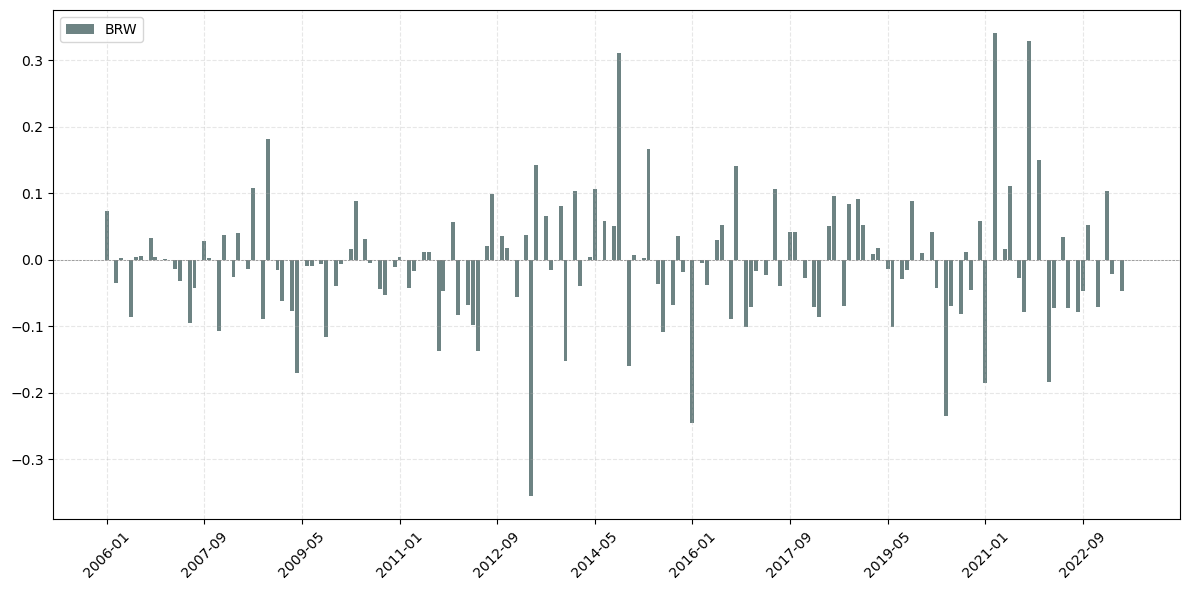

In [29]:
# Seus dados
mdate_values = data_monthly["mdate"]
new_shock_values = data_monthly["BRW_daily"]

# Configuração do estilo do gráfico
plt.figure(figsize=(12, 6))
plt.bar(mdate_values, new_shock_values, color='DarkSlateGray', alpha=0.7, label='BRW')

# Comentando as linhas relacionadas ao gráfico de linha
# plt.plot(mdate_values, new_shock_values, color='DarkSlateGray', linewidth=2, label='BRW')
# plt.title("BRW Shock - Brazil")
# plt.xlabel("Data")
# plt.ylabel("Valor do Choque")

plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(loc='upper left')



# Personalização do eixo x
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(nbins=12))
plt.xticks(rotation=45)

# Adicionando grade horizontal
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)

# Ajustando margens e espaçamento
plt.tight_layout()

# Exportar o gráfico como um arquivo PNG
plt.savefig('brw_shock_bar_graph.png', dpi=300, bbox_inches='tight')


# Exibindo o gráfico
plt.show()



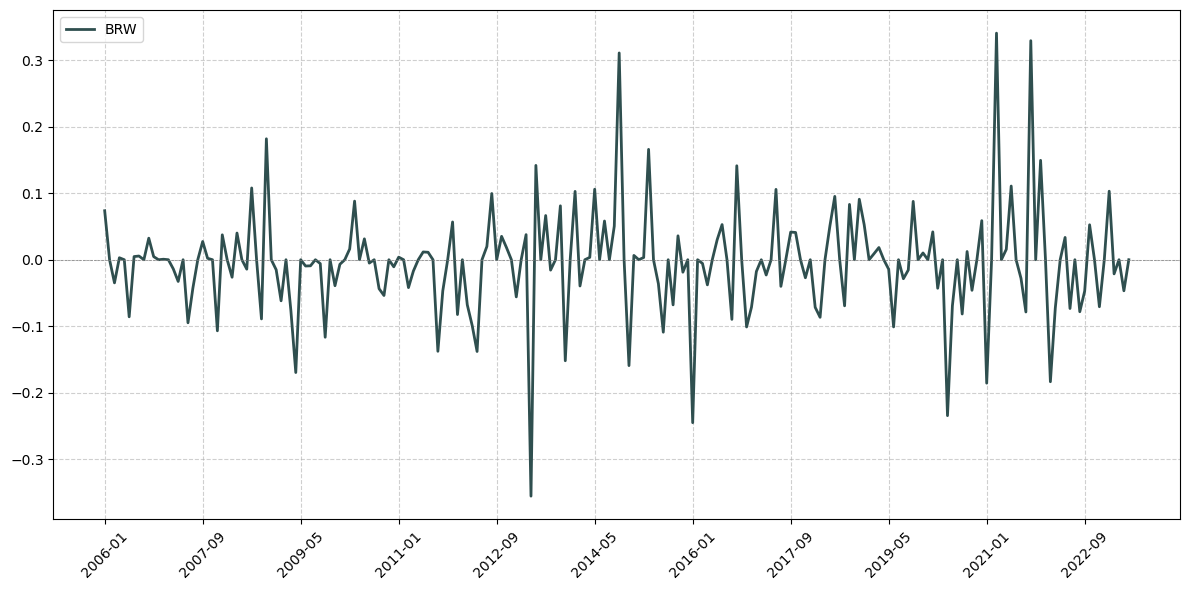

In [30]:


# Converter valores do tipo Period para datetime
mdate_values = data_monthly["mdate"]
new_shock_values = data_monthly["BRW_daily"]

# Configuração do estilo do gráfico
plt.figure(figsize=(12, 6))
plt.plot(mdate_values, new_shock_values, color='DarkSlateGray', linewidth=2, label='BRW')
#plt.title("BRW Shock - Brazil")
#plt.xlabel("Data")
#plt.ylabel("Valor do Choque")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper left')

# Personalização do eixo x
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(nbins=12))
plt.xticks(rotation=45)

# Adicionando grade horizontal
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)

# Ajustando margens e espaçamento
plt.tight_layout()

# Exportar o gráfico como um arquivo PNG
plt.savefig('brw_shock_graph.png', dpi=300, bbox_inches='tight')

# Exibindo o gráfico
plt.show()


### Shock Construction Robustness

In [31]:
### IV2 refers to the BRW shock series aligned using daily movements in the policy indicator 2-days after COPOM announcement day rather than one week as the instrumental variable### IV2 refers to the BRW shock series aligned using daily movements in the policy indicator 2-days after COPOM announcement day rather than one week as the instrumental variable

data_iv2 = data_complete[data_complete["q"].isin([1, 2])].copy()
step_1(data_iv2,list_maturities,2)
data_iv2 = step_2(data_iv2)
renormalization(data_iv2)

### IV7 refers to the BRW shock series aligned using daily movements in the policy indicator 7-days after COPOM announcement day rather than one week as the instrumental variable

data_iv7 = data_complete[data_complete["q"].isin([1, 3])].copy()
step_1(data_iv7,list_maturities,3)
data_iv7 = step_2(data_iv7)
renormalization(data_iv7)

### IV1 refers to the BRW shock series aligned using daily movements in the policy indicator 1-day before COPOM announcement day rather than one week as the instrumental variable### IV2 refers to the BRW shock series aligned using daily movements in the policy indicator 2-days after COPOM announcement day rather than one week as the instrumental variable

data_iv1 = data_complete[data_complete["q"].isin([1, 4])].copy()
step_1(data_iv1,list_maturities,4)
data_iv1 = step_2(data_iv1)
renormalization(data_iv1)


### R5 refers to the BRW shock series aligned using zero-coupon yields with only the 1, 2, 5, 10, 30-year maturities as outcome variables

list_maturities_R5 = ["01", "02", "05", "10", "30"]
data_R5 = data_brw[["date","dgs_d","q","mdate", "SVENY01_d","SVENY02_d", "SVENY05_d", "SVENY10_d", "SVENY30_d"]]
step_1(data_R5,list_maturities_R5,0)
data_R5 = step_2(data_R5)
renormalization(data_R5)

### R10 refers to the BRW shock series aligned using zero-coupon yields with only the 1 to 10-year maturities as outcome variables

list_maturities_R10 = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10"]
data_R10 = data_brw[["date","dgs_d","q","mdate", "SVENY01_d","SVENY02_d", "SVENY03_d","SVENY04_d","SVENY05_d","SVENY06_d","SVENY07_d","SVENY08_d","SVENY09_d", "SVENY10_d"]]
step_1(data_R10,list_maturities_R10,0)
data_R10 = step_2(data_R10)
renormalization(data_R10)

### Day2 refers to the BRW shock series aligned using a 2-day event window around COPOM announcement days

data_day2 = data_brw
for num in list_maturities:
    col_name = f'SVENY{num}'
    yield_data[f'{col_name}_d'] = yield_data[col_name] - yield_data[col_name].shift(2)
data_day2 = merged_data.merge(yield_data, on=['date','mdate'], how='inner')
step_1(data_day2,list_maturities,0)
data_day2 = step_2(data_day2)
renormalization(data_day2)

### B3 refers to the BRW shock series aligned using the BM&F Pre x DI Curve
data_swap = pd.read_excel(r"C:\Users\Alysson\Documents\GitHub\Monetary-Shocks\Brasil\BRW\swap_br.xlsx")
list_maturities_b3 = [str(i).zfill(2) for i in range(1, 16)]
for num in list_maturities_b3:
    col_name = f'SVENY{num}'
    data_swap[f'{col_name}_d'] = data_swap[col_name] - data_swap[col_name].shift(1)
data_swap['date'] = pd.to_datetime(data_swap['Date'], format='%Y-%m-%d')
data_swap = merged_data.merge(data_swap, on=['date'], how='inner')
step_1(data_swap,list_maturities_b3,0)
data_swap = step_2(data_swap)
renormalization(data_swap)


### BBG refers to the BRW shock series aligned using the BRL Curva de soberanos from Bloomberg
data_BBG = pd.read_excel(r"C:\Users\Alysson\Documents\GitHub\Monetary-Shocks\Brasil\BRW\Curva Brasil - BBG.xlsx")
for num in list_maturities_R10:
    col_name = f'SVENY{num}'
    data_BBG[f'{col_name}_d'] = data_BBG[col_name] - data_BBG[col_name].shift(1)
data_BBG['date'] = pd.to_datetime(data_BBG['Date'], format='%Y-%m-%d')
data_BBG = merged_data.merge(data_BBG, on=['date'], how='inner')
step_1(data_BBG,list_maturities_R10,0)
data_BBG = step_2(data_BBG)
renormalization(data_BBG)




columns_2 = data_iv2[['mdate', 'BRW_daily']]
columns_2.isetitem(columns_2.columns.get_loc('mdate'), columns_2['mdate'].dt.strftime('%Y-%m'))

columns_7 = data_iv7[['mdate', 'BRW_daily']]
columns_7.isetitem(columns_7.columns.get_loc('mdate'), columns_7['mdate'].dt.strftime('%Y-%m'))

columns_1 = data_iv1[['mdate', 'BRW_daily']]
columns_1.isetitem(columns_1.columns.get_loc('mdate'), columns_1['mdate'].dt.strftime('%Y-%m'))

columns_R5 = data_R5[['mdate', 'BRW_daily']]
columns_R5.isetitem(columns_R5.columns.get_loc('mdate'), columns_R5['mdate'].dt.strftime('%Y-%m'))

columns_R10 = data_R10[['mdate', 'BRW_daily']]
columns_R10.isetitem(columns_R10.columns.get_loc('mdate'), columns_R10['mdate'].dt.strftime('%Y-%m'))

columns_day2 = data_day2[['mdate', 'BRW_daily']]
columns_day2.isetitem(columns_day2.columns.get_loc('mdate'), columns_day2['mdate'].dt.strftime('%Y-%m'))

columns_b3 = data_swap[['mdate', 'BRW_daily']]
columns_b3.isetitem(columns_b3.columns.get_loc('mdate'), columns_b3['mdate'].dt.strftime('%Y-%m'))

columns_BBG = data_BBG[['mdate', 'BRW_daily']]
columns_BBG.isetitem(columns_BBG.columns.get_loc('mdate'), columns_BBG['mdate'].dt.strftime('%Y-%m'))

data_monthly = data_monthly.merge(columns_2, on='mdate', how='left', suffixes=['', '_iv2'])
data_monthly['BRW_daily_iv2'].fillna(0, inplace=True)
data_monthly = data_monthly.merge(columns_7, on='mdate', how='left', suffixes = ['', '_iv7'])
data_monthly['BRW_daily_iv7'].fillna(0, inplace=True)
data_monthly = data_monthly.merge(columns_1, on='mdate', how='left', suffixes = ['', '_iv1'])
data_monthly['BRW_daily_iv1'].fillna(0, inplace=True)
data_monthly = data_monthly.merge(columns_R5, on='mdate', how='left', suffixes = ['', '_R5'])
data_monthly['BRW_daily_R5'].fillna(0, inplace=True)
data_monthly = data_monthly.merge(columns_R10, on='mdate', how='left', suffixes = ['', '_R10'])
data_monthly['BRW_daily_R10'].fillna(0, inplace=True)
data_monthly = data_monthly.merge(columns_day2, on='mdate', how='left', suffixes = ['', '_day2'])
data_monthly['BRW_daily_day2'].fillna(0, inplace=True)
data_monthly = data_monthly.merge(columns_b3, on='mdate', how='left', suffixes = ['', '_b3'])
data_monthly['BRW_daily_b3'].fillna(0, inplace=True)
data_monthly = data_monthly.merge(columns_BBG, on='mdate', how='left', suffixes = ['', '_BBG'])
data_monthly['BRW_daily_BBG'].fillna(0, inplace=True)





                          IV-2SLS Estimation Summary                          
Dep. Variable:              SVENY01_d   R-squared:                     -1.4038
Estimator:                    IV-2SLS   Adj. R-squared:                -1.4125
No. Observations:                 278   F-statistic:                    7.0806
Date:                Mon, Nov 27 2023   P-value (F-stat)                0.0078
Time:                        10:14:54   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          0.0091     0.0136     0.6733     0.5008     -0.0175      0.0358
dgs_d          2.0490     0.7700     2.6609     0.00

                          IV-2SLS Estimation Summary                          
Dep. Variable:              SVENY12_d   R-squared:                     -0.0254
Estimator:                    IV-2SLS   Adj. R-squared:                -0.0291
No. Observations:                 278   F-statistic:                    0.9961
Date:                Mon, Nov 27 2023   P-value (F-stat)                0.3182
Time:                        10:14:54   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          0.0249     0.0092     2.7116     0.0067      0.0069      0.0429
dgs_d          0.2830     0.2836     0.9981     0.31

                          IV-2SLS Estimation Summary                          
Dep. Variable:              SVENY23_d   R-squared:                     -0.0016
Estimator:                    IV-2SLS   Adj. R-squared:                -0.0052
No. Observations:                 278   F-statistic:                    0.0043
Date:                Mon, Nov 27 2023   P-value (F-stat)                0.9479
Time:                        10:14:55   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          0.0228     0.0102     2.2389     0.0252      0.0028      0.0428
dgs_d          0.0215     0.3299     0.0653     0.94

C:\Users\Alysson\AppData\Local\Temp\ipykernel_24592\1197651082.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.loc[:, "new_shock"] = aligned_dgs_d.copy()
C:\Users\Alysson\AppData\Local\Temp\ipykernel_24592\1197651082.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.loc[:, "new_shock"] = dataframe["new_shock"].apply(lambda x: x[0])
C:\Users\Alysson\AppData\Local\Temp\ipykernel_24592\1197651082.py:27: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt 

                          IV-2SLS Estimation Summary                          
Dep. Variable:              SVENY01_d   R-squared:                      0.1420
Estimator:                    IV-2SLS   Adj. R-squared:                 0.1389
No. Observations:                 278   F-statistic:                    34.067
Date:                Mon, Nov 27 2023   P-value (F-stat)                0.0000
Time:                        10:14:55   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const         -0.0052     0.0070    -0.7363     0.4615     -0.0190      0.0086
dgs_d          1.4262     0.2443     5.8367     0.00

                          IV-2SLS Estimation Summary                          
Dep. Variable:              SVENY11_d   R-squared:                      0.0101
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0065
No. Observations:                 278   F-statistic:                    0.0350
Date:                Mon, Nov 27 2023   P-value (F-stat)                0.8516
Time:                        10:14:55   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          0.0072     0.0083     0.8610     0.3892     -0.0092      0.0235
dgs_d          0.0356     0.1902     0.1871     0.85

                          IV-2SLS Estimation Summary                          
Dep. Variable:              SVENY21_d   R-squared:                     -0.0288
Estimator:                    IV-2SLS   Adj. R-squared:                -0.0325
No. Observations:                 278   F-statistic:                    0.5846
Date:                Mon, Nov 27 2023   P-value (F-stat)                0.4445
Time:                        10:14:56   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          0.0090     0.0097     0.9284     0.3532     -0.0100      0.0279
dgs_d         -0.1764     0.2307    -0.7646     0.44

C:\Users\Alysson\AppData\Local\Temp\ipykernel_24592\1197651082.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.loc[:, "new_shock"] = aligned_dgs_d.copy()
C:\Users\Alysson\AppData\Local\Temp\ipykernel_24592\1197651082.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.loc[:, "new_shock"] = dataframe["new_shock"].apply(lambda x: x[0])
C:\Users\Alysson\AppData\Local\Temp\ipykernel_24592\1197651082.py:27: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt 

                          IV-2SLS Estimation Summary                          
Dep. Variable:              SVENY01_d   R-squared:                     -4.0170
Estimator:                    IV-2SLS   Adj. R-squared:                -4.0352
No. Observations:                 278   F-statistic:                    0.1410
Date:                Mon, Nov 27 2023   P-value (F-stat)                0.7073
Time:                        10:14:56   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const         -0.0206     0.0314    -0.6552     0.5124     -0.0821      0.0410
dgs_d         -1.2031     3.2046    -0.3754     0.70

                          IV-2SLS Estimation Summary                          
Dep. Variable:              SVENY12_d   R-squared:                     -1.7380
Estimator:                    IV-2SLS   Adj. R-squared:                -1.7479
No. Observations:                 278   F-statistic:                    0.6419
Date:                Mon, Nov 27 2023   P-value (F-stat)                0.4230
Time:                        10:14:56   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          0.0216     0.0235     0.9208     0.3571     -0.0244      0.0676
dgs_d          1.7618     2.1990     0.8012     0.42

                          IV-2SLS Estimation Summary                          
Dep. Variable:              SVENY23_d   R-squared:                     -2.8781
Estimator:                    IV-2SLS   Adj. R-squared:                -2.8922
No. Observations:                 278   F-statistic:                    0.5191
Date:                Mon, Nov 27 2023   P-value (F-stat)                0.4712
Time:                        10:14:57   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          0.0296     0.0328     0.9018     0.3672     -0.0347      0.0938
dgs_d          2.2758     3.1587     0.7205     0.47

C:\Users\Alysson\AppData\Local\Temp\ipykernel_24592\1197651082.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.loc[:, "new_shock"] = aligned_dgs_d.copy()
C:\Users\Alysson\AppData\Local\Temp\ipykernel_24592\1197651082.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.loc[:, "new_shock"] = dataframe["new_shock"].apply(lambda x: x[0])
C:\Users\Alysson\AppData\Local\Temp\ipykernel_24592\1197651082.py:27: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt 

                          IV-2SLS Estimation Summary                          
Dep. Variable:              SVENY01_d   R-squared:                      0.7003
Estimator:                    IV-2SLS   Adj. R-squared:                 0.6981
No. Observations:                 139   F-statistic:                    1752.3
Date:                Mon, Nov 27 2023   P-value (F-stat)                0.0000
Time:                        10:14:57   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const         -0.0035     0.0079    -0.4386     0.6609     -0.0190      0.0121
dgs_d          0.9755     0.0233     41.860     0.00

C:\Users\Alysson\AppData\Local\Temp\ipykernel_24592\1197651082.py:27: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dataframe.loc[:, "new_shock"] = dataframe["new_shock"].apply(lambda x: x[0])
C:\Users\Alysson\AppData\Local\Temp\ipykernel_24592\1539200891.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe["const"] = 1
C:\Users\Alysson\AppData\Local\Temp\ipykernel_24592\1539200891.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

                          IV-2SLS Estimation Summary                          
Dep. Variable:              SVENY01_d   R-squared:                      0.7003
Estimator:                    IV-2SLS   Adj. R-squared:                 0.6981
No. Observations:                 139   F-statistic:                    1752.3
Date:                Mon, Nov 27 2023   P-value (F-stat)                0.0000
Time:                        10:14:57   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const         -0.0035     0.0079    -0.4386     0.6609     -0.0190      0.0121
dgs_d          0.9755     0.0233     41.860     0.00

C:\Users\Alysson\AppData\Local\Temp\ipykernel_24592\1197651082.py:27: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dataframe.loc[:, "new_shock"] = dataframe["new_shock"].apply(lambda x: x[0])
C:\Users\Alysson\anaconda3\Lib\site-packages\linearmodels\iv\model.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(
C:\Users\Alysson\anaconda3\Lib\site-packages\linearmodels\iv\model.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(
C:\Users\Alysson\anaconda3\Lib\site-packages\linearmodels\iv\model.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(
C:\Users\Alys

                          IV-2SLS Estimation Summary                          
Dep. Variable:              SVENY01_d   R-squared:                      0.3514
Estimator:                    IV-2SLS   Adj. R-squared:                 0.3491
No. Observations:                 278   F-statistic:                    25.044
Date:                Mon, Nov 27 2023   P-value (F-stat)                0.0000
Time:                        10:14:58   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const         -0.0032     0.0080    -0.4020     0.6877     -0.0189      0.0125
dgs_d          1.2933     0.2584     5.0044     0.00

C:\Users\Alysson\anaconda3\Lib\site-packages\linearmodels\iv\model.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(
C:\Users\Alysson\anaconda3\Lib\site-packages\linearmodels\iv\model.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(
C:\Users\Alysson\anaconda3\Lib\site-packages\linearmodels\iv\model.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(
C:\Users\Alysson\anaconda3\Lib\site-packages\linearmodels\iv\model.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(
C:\Users\Alysson\anaconda3\Lib\site-packages\linearmodels\iv\model.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(
C:\Users\Alysson\anaconda3\Lib\site-packages\linearmode

                          IV-2SLS Estimation Summary                          
Dep. Variable:              SVENY08_d   R-squared:                     -0.1163
Estimator:                    IV-2SLS   Adj. R-squared:                -0.1204
No. Observations:                 278   F-statistic:                    0.4564
Date:                Mon, Nov 27 2023   P-value (F-stat)                0.4993
Time:                        10:14:58   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          0.0016     0.0155     0.1034     0.9176     -0.0287      0.0319
dgs_d         -0.3731     0.5523    -0.6756     0.49

C:\Users\Alysson\anaconda3\Lib\site-packages\linearmodels\iv\model.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(
C:\Users\Alysson\anaconda3\Lib\site-packages\linearmodels\iv\model.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(
C:\Users\Alysson\anaconda3\Lib\site-packages\linearmodels\iv\model.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(
C:\Users\Alysson\anaconda3\Lib\site-packages\linearmodels\iv\model.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(
C:\Users\Alysson\anaconda3\Lib\site-packages\linearmodels\iv\model.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(
C:\Users\Alysson\anaconda3\Lib\site-packages\linearmode

                          IV-2SLS Estimation Summary                          
Dep. Variable:              SVENY16_d   R-squared:                     -0.1385
Estimator:                    IV-2SLS   Adj. R-squared:                -0.1426
No. Observations:                 278   F-statistic:                    1.1907
Date:                Mon, Nov 27 2023   P-value (F-stat)                0.2752
Time:                        10:14:58   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const         -0.0086     0.0181    -0.4728     0.6363     -0.0442      0.0270
dgs_d         -0.7080     0.6488    -1.0912     0.27

C:\Users\Alysson\anaconda3\Lib\site-packages\linearmodels\iv\model.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(
C:\Users\Alysson\anaconda3\Lib\site-packages\linearmodels\iv\model.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(
C:\Users\Alysson\anaconda3\Lib\site-packages\linearmodels\iv\model.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(
C:\Users\Alysson\anaconda3\Lib\site-packages\linearmodels\iv\model.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(
C:\Users\Alysson\anaconda3\Lib\site-packages\linearmodels\iv\model.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(
C:\Users\Alysson\anaconda3\Lib\site-packages\linearmode

                          IV-2SLS Estimation Summary                          
Dep. Variable:              SVENY24_d   R-squared:                     -0.0986
Estimator:                    IV-2SLS   Adj. R-squared:                -0.1026
No. Observations:                 278   F-statistic:                    1.2372
Date:                Mon, Nov 27 2023   P-value (F-stat)                0.2660
Time:                        10:14:58   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const         -0.0143     0.0204    -0.7037     0.4816     -0.0543      0.0256
dgs_d         -0.8034     0.7223    -1.1123     0.26

C:\Users\Alysson\AppData\Local\Temp\ipykernel_24592\1197651082.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.loc[:, "new_shock"] = aligned_dgs_d.copy()
C:\Users\Alysson\AppData\Local\Temp\ipykernel_24592\1197651082.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.loc[:, "new_shock"] = dataframe["new_shock"].apply(lambda x: x[0])
C:\Users\Alysson\AppData\Local\Temp\ipykernel_24592\1197651082.py:27: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt 

                          IV-2SLS Estimation Summary                          
Dep. Variable:              SVENY01_d   R-squared:                      0.5428
Estimator:                    IV-2SLS   Adj. R-squared:                 0.5412
No. Observations:                 278   F-statistic:                    47.748
Date:                Mon, Nov 27 2023   P-value (F-stat)                0.0000
Time:                        10:14:59   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const         -0.0026     0.0056    -0.4661     0.6411     -0.0136      0.0084
dgs_d          1.2311     0.1782     6.9100     0.00

C:\Users\Alysson\anaconda3\Lib\site-packages\linearmodels\iv\model.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(
C:\Users\Alysson\anaconda3\Lib\site-packages\linearmodels\iv\model.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(
C:\Users\Alysson\anaconda3\Lib\site-packages\linearmodels\iv\model.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(
C:\Users\Alysson\anaconda3\Lib\site-packages\linearmodels\iv\model.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(
C:\Users\Alysson\anaconda3\Lib\site-packages\linearmodels\iv\model.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(
C:\Users\Alysson\anaconda3\Lib\site-packages\linearmode

                          IV-2SLS Estimation Summary                          
Dep. Variable:              SVENY10_d   R-squared:                     -0.0684
Estimator:                    IV-2SLS   Adj. R-squared:                -0.0723
No. Observations:                 278   F-statistic:                    0.0969
Date:                Mon, Nov 27 2023   P-value (F-stat)                0.7556
Time:                        10:15:00   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const         -0.0021     0.0100    -0.2126     0.8316     -0.0217      0.0175
dgs_d         -0.1182     0.3799    -0.3112     0.75

C:\Users\Alysson\AppData\Local\Temp\ipykernel_24592\1197651082.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.loc[:, "new_shock"] = aligned_dgs_d.copy()
C:\Users\Alysson\AppData\Local\Temp\ipykernel_24592\1197651082.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.loc[:, "new_shock"] = dataframe["new_shock"].apply(lambda x: x[0])
C:\Users\Alysson\AppData\Local\Temp\ipykernel_24592\1197651082.py:27: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt 

                          IV-2SLS Estimation Summary                          
Dep. Variable:              SVENY01_d   R-squared:                      0.4274
Estimator:                    IV-2SLS   Adj. R-squared:                 0.4251
No. Observations:                 258   F-statistic:                    40.907
Date:                Mon, Nov 27 2023   P-value (F-stat)                0.0000
Time:                        10:15:01   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const         -0.0006     0.0061    -0.1062     0.9154     -0.0126      0.0113
dgs_d          1.1697     0.1829     6.3958     0.00

C:\Users\Alysson\AppData\Local\Temp\ipykernel_24592\1197651082.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.loc[:, "new_shock"] = aligned_dgs_d.copy()
C:\Users\Alysson\AppData\Local\Temp\ipykernel_24592\1197651082.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.loc[:, "new_shock"] = dataframe["new_shock"].apply(lambda x: x[0])
C:\Users\Alysson\AppData\Local\Temp\ipykernel_24592\1197651082.py:27: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt 

In [32]:
data_monthly

,mdate,BRW_daily,BRW_daily_iv2,BRW_daily_iv7,BRW_daily_iv1,BRW_daily_R5,BRW_daily_R10,BRW_daily_day2,BRW_daily_b3,BRW_daily_BBG
0,2006-01,0.073583,0.078393,0.077005,0.071414,0.040127,-0.004032,0.058962,-0.063733,0.000000
1,2006-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2006-03,-0.034759,-0.033431,-0.033822,-0.033114,-0.037867,-0.038468,-0.022126,-0.006173,0.000000
3,2006-04,0.002962,0.005697,0.004909,0.001509,-0.012639,-0.021491,-0.246398,0.044352,0.000000
4,2006-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
205,2023-02,0.102943,0.097907,0.099407,0.097622,0.120478,0.129054,0.049681,0.089987,-0.017264
206,2023-03,-0.021251,-0.023384,-0.022780,-0.018203,-0.006256,-0.000973,0.001162,0.002326,0.014155
207,2023-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
208,2023-05,-0.046660,-0.048233,-0.047808,-0.041706,-0.032702,-0.028439,-0.003944,-0.018512,-0.022351


In [33]:
robustness = {
    'iv 2': [data_monthly['BRW_daily'].corr(data_monthly['BRW_daily_iv2']), "Using the 2-day post-COPOM  movements in the policy indicator for IV"],
    'iv 7': [data_monthly['BRW_daily'].corr(data_monthly['BRW_daily_iv7']), "Using the 7-day post-COPOM  movements in the policy indicator for IV"],
    'iv -1': [data_monthly['BRW_daily'].corr(data_monthly['BRW_daily_iv1']), "Using the day-before COPOM policy indicator for IV"],
    'R5': [data_monthly['BRW_daily'].corr(data_monthly['BRW_daily_R5']), "Employing only yields from the 1, 2, 5, 10, and 30-year maturities as the dependent variables"],
    'R10': [data_monthly['BRW_daily'].corr(data_monthly['BRW_daily_R10']), "Employing  yields with only the 1 to 10-year maturities as outcome variables"],
    'day2': [data_monthly['BRW_daily'].corr(data_monthly['BRW_daily_day2']), "Using a 2-day event window around COPOM announcement days"],
    'b3': [data_monthly['BRW_daily'].corr(data_monthly['BRW_daily_b3']), "B3 refers to the BRW shock series aligned using the BM&F Pre x DI Curve (1y to 15y)"],
    'b3_R10': [data_monthly['BRW_daily_R10'].corr(data_monthly['BRW_daily_b3']), "Correlation between 1-year to 10-year R10 and B3 shocks"],
    'BBG': [data_monthly.iloc[15:]['BRW_daily_BBG'].corr(data_monthly['BRW_daily'].iloc[15:]),"BBG references the BRW shock series by utilizing the BRL Sovereign Curve from Bloomberg"]
    
}

summary_robustness = pd.DataFrame.from_dict(robustness, orient='index', columns=[['Correlation','Explain']])

summary_robustness

,Correlation,Explain
iv 2,0.998853,Using the 2-day post-COPOM movements in the p...
iv 7,0.999412,Using the 7-day post-COPOM movements in the p...
iv -1,0.998618,Using the day-before COPOM policy indicator fo...
R5,0.980459,"Employing only yields from the 1, 2, 5, 10, an..."
R10,0.804066,Employing yields with only the 1 to 10-year m...
day2,0.863888,Using a 2-day event window around COPOM announ...
b3,0.714879,B3 refers to the BRW shock series aligned usin...
b3_R10,0.876540,Correlation between 1-year to 10-year R10 and ...
BBG,0.731127,BBG references the BRW shock series by utilizi...


In [34]:
subset_data = data_monthly

# Especifique o nome do arquivo Excel de saída
output_file = "data_subset.xlsx"

# Salve o DataFrame no arquivo Excel
subset_data.to_excel(output_file, index=False)